<img src="https://www.digitalhouse.com/logo-DH.png" width="200" height="100" align="left">

<h3><b>Curso:</b> Data Science / <b>Año:</b> 2020 / <b>Sede:</b> Casa</h3>

-----

<h3><b>TP Integrador:</b> Text Mining de <i>tweets</i> de anuncios del gobierno durante la cuarentena.</h3>
<blockquote>
        <ul>
          <li><i>Sentiment analysis</i> de los comentarios de los usuarios.</li>
          <li>Clustering de <i>tweets</i> de los usuarios.</li>
        </ul>
</blockquote>

<h3><b>Grupo 10:</b></h3>
<blockquote>
        <ul>
          <li>Maria Eugenia Perotti</li>
          <li>Gastón Ortíz</li>
        </ul>
</blockquote>

# Sobre el trabajo.

Nuestra propuesta es realizar _text mining_ sobre tweets publicados durante la cuarentena, concentrándonos específicamente en las fechas en las que el presidente hace los anuncios relacionados al distanciamiento social preventivo y obligatorio.

## Criterios de búsqueda.
Debido al gran volumen de _tweets_ y a las limitaciones de la biblioteca que estamos utilizando, nos vimos forzados a limitar los criterios de búsqueda.

<b><u>Ciudades:</u></b>
* Buenos Aires
* Cordoba
* Rosario
* Mendoza
* Tucumán
* San Juan
* Neuquén
* Paraná
* Comodoro Rivadavia

<b><u>Cuentas:</u></b>
* Ministerio de Salud de la Nación | @msalnacion
* Casa Rosada | @CasaRosada
* Horacio Rodríguez Larreta | @horaciorlarreta
* Alberto Fernández | @alferdez
* Alberto Fernández Prensa | @alferdezprensa
* Axel Kicillof | @Kicillofok
* Cristina Kirchner | @CFKArgentina

<b><u>Hashtags:</u></b>
* #covid19
* #covid
* #coronavirus
* #cuarentena
* #albertofernandez

# Preparación de libraries y funciones.

## Configuración Colab.

In [206]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install GetOldTweets3
    !pip install unidecode
    ruta_drive = "/content/drive/My Drive/TP Integrador/Notebooks/Data/"
except ModuleNotFoundError:    
    print("Se está trabajando localmente")

Se está trabajando localmente


## Imports.

In [207]:
import numpy as np
import pandas as pd
import GetOldTweets3 as got
import datetime
from textblob import TextBlob
import re
import unidecode
import matplotlib.pyplot as plt
import time
import os
import glob


## Definición de funciones.
En esta sección definimos las funciones que vamos a utilizar en la notebook.

### Función para obtener los tweets de acuerdo a los criterios de búsqueda.

In [208]:
def get_tweets(list_criterios, fecha_inicio, fecha_final, maximo=250):
    tweets_total = []
    for criterio in list_criterios:
        tweetCriteria = got.manager.TweetCriteria().setQuerySearch(criterio).setSince(fecha_inicio).setUntil(fecha_final).setMaxTweets(maximo)
        tweets_total = got.manager.TweetManager.getTweets(tweetCriteria)
    return tweets_total

### Función para limpiar los tweets.

In [209]:
def limpiar(tweet_texto):
    text = ' '.join(re.sub(r"(@)|([^0-9A-Za-z \t])|(www.[^ ]+)|(https?://[^ ]+)", "", unidecode.unidecode(tweet_texto.lower())).split())
    return text

### Función para crear un dataframe en base a los tweets.

In [210]:
def create_df(tweets_anuncios):
    datos = []
    for anuncio in tweets_anuncios:
        for ciudad in tweets_anuncios[anuncio]: 
            for tweet in tweets_anuncios[anuncio][ciudad]:
                registro = {'username': tweet.username, 'tweet': limpiar(tweet.text), \
                            'fecha': tweet.date, 'anuncio':anuncio, 'ubicacion':ciudad, 'id':tweet.id}
                datos.append(registro)
    df = pd.DataFrame(data=datos)    
    return df

### Función para limpiar dataframe.

In [211]:
#definimos una lista negra de los usuarios que vamos a eliminar
usuarios_blacklist = ['sergistack', 'GamesRedDeer']
usuarios_medios = ['gustavorearte1','gerdellamonica','radiofonica1007',' pmgcharly',' NTodxs',' Noticiasde_',' nora_verges',' mnspezzapria',' METRO_RADIO_TV',' MartinD50004804',' mariogaloppo',' LUIS20GEREZ',' losprimerostuc',' lacriticaok',' lacapital',' IldefonsoM',' HernanMundo',' elsolquilmes',' ellitoral',' cronica',' cordoba',' Contexto_Tuc',' ConLaGenteRos',' con_sello',' Cadena3Com',' AvellanedaReal',' AiredeSantaFe',' AgenciaDib',' Adry1BC',' ADNsur',' abccordoba',' 104Urbana']
topicos_excluidos = ['barcelona', 'bayern munich', 'barca', 'bayern', 'barsa', 'anabelle', 'annabell', 'annabelle', 'messi', 'balvin', 'pampita']

def clean_up_df(df):
    #definimos una máscara para excluir a los usuarios en la lista negra
    mask_not_bl = [x not in usuarios_blacklist for x in df['username']] 
    df = df[mask_not_bl]
    #definimos una máscara para excluir a los usuarios en la lista negra
    mask_not_media = [x not in usuarios_medios for x in df['username']] 
    df = df[mask_not_media]
    df.drop_duplicates(subset=['tweet'], keep=False, inplace=True)
    # máscara de tópicos excluidos
    mask_not_topics = [x not in topicos for x in df['tweet']] 
    df = df[mask_not_topics]
    
    try:
        df.drop(columns=['index'], axis=0, inplace=True)
    except:
        print("No existe la columna index")
        
    try:
        df.drop(columns=['fecha_sola'], axis=0, inplace=True)
    except:
        print("No existe la columna fecha_sola")
        
    return df

# Obtención de tweets.
En esta sección definimos los criterios de búsqueda y ejecutamos las funciones descritas previamente.

## Llamado a la API para obtener los tweets.

Procedemos a declarar los parámetros que utilizaremos para las búsquedas:

In [212]:
fecha_inicio = ["2020-03-19T21:00:38Z","2020-03-29T20:00:38Z","2020-04-10T20:00:38Z","2020-04-25T18:00:38Z","2020-05-08T20:00:38Z","2020-05-23T20:00:38Z","2020-06-04T20:00:38Z","2020-06-26T18:00:38Z","2020-07-17T14:00:38Z","2020-07-31T14:00:38Z","2020-08-14T14:00:38Z"]
fecha_final =  ["2020-03-20T04:00:38Z","2020-03-30T04:00:38Z","2020-04-11T04:00:38Z","2020-04-26T04:00:38Z","2020-05-09T04:00:38Z","2020-05-24T04:00:38Z","2020-06-05T04:00:38Z","2020-06-27T04:00:38Z","2020-07-18T04:00:38Z","2020-08-01T04:00:38Z","2020-08-15T04:00:38Z"]
criterios = ["cuarentena","msalnacion","CasaRosada","alferdez", "alferdezprensa"]
#ciudades = ["Buenos Aires, Argentina"],"Cordoba, Argentina","Rosario, Argentina","Mendoza, Argentina", "Tucumán, Argentina","Paraná, Argentina"
ciudades = ["Cordoba, Argentina"]
#ciudades = ["Rosario, Argentina"]
#ciudades = ["Mendoza, Argentina"]
#ciudades = ["Tucumán, Argentina"]
#ciudades = ["Paraná, Argentina"]
#radio = "200km"
maximo = 1000

Ejecutamos la función para traer los tweets:

In [213]:
dic_tweets = {}
for i in range(len(fecha_inicio)):
    dic_tweets["Anuncio_"+str(i+1)] = {}
    for ciudad in ciudades:
        try:
            dic_tweets["Anuncio_"+str(i+1)][ciudad] = get_tweets(criterios,fecha_inicio[i],fecha_final[i],maximo)
        except:
            continue
    print(i)

0
1
2
An error occured during an HTTP request: HTTP Error 429: Too Many Requests
Try to open in browser: https://twitter.com/search?q=alferdez%20since%3A2020-04-25T18%3A00%3A38Z%20until%3A2020-04-26T04%3A00%3A38Z&src=typd
3
An error occured during an HTTP request: HTTP Error 429: Too Many Requests
Try to open in browser: https://twitter.com/search?q=cuarentena%20since%3A2020-05-08T20%3A00%3A38Z%20until%3A2020-05-09T04%3A00%3A38Z&src=typd
4
An error occured during an HTTP request: HTTP Error 429: Too Many Requests
Try to open in browser: https://twitter.com/search?q=cuarentena%20since%3A2020-05-23T20%3A00%3A38Z%20until%3A2020-05-24T04%3A00%3A38Z&src=typd
5
An error occured during an HTTP request: HTTP Error 429: Too Many Requests
Try to open in browser: https://twitter.com/search?q=cuarentena%20since%3A2020-06-04T20%3A00%3A38Z%20until%3A2020-06-05T04%3A00%3A38Z&src=typd
6
An error occured during an HTTP request: HTTP Error 429: Too Many Requests
Try to open in browser: https://twitter.c

### Creación del dataframe.

Ejecutamos la función para crear el dataframe y le pasamos como parámetros los tweets:

In [214]:
df = create_df(dic_tweets)

Verificamos que haya creado exitosamente el dataframe:

In [215]:
df.head(3)

,username,tweet,fecha,anuncio,ubicacion,id
0,GonzaloBuxo,apoyo total las medidas fuerza presidente esta demostrando seriedad,2020-03-19 23:59:45+00:00,Anuncio_1,"Cordoba, Argentina",1240790092408672257
1,sergistack,usas google chrome lo siento por las mayusculas pero existe un nuevo navegador que es mas rapido y mas privado que chrome bloquea los anuncios y los rastreadores lo cual ahorra tiempo de carga la interfaz es exactamente igual que la de chrome brave lo supera en todo,2020-03-28 20:07:18+00:00,Anuncio_1,"Cordoba, Argentina",1243993087531266049
2,gacela2019,asi lo hacemos sr presidente,2020-03-19 23:58:50+00:00,Anuncio_1,"Cordoba, Argentina",1240789862191685639


In [216]:
df.shape

(1001, 6)

#### Creación de variable _target_: `sentimiento`.

Una vez que comprobamos que está todo OK, agregamos la columna sentimiento y procedemos a exportar los tweets a un .csv para preservar la muestra. Usamos como separador el `;` para que cuando lo abramos en Excel se divida automáticamente en columnas.

Crearemos la variable target para, posteriormente, poder realizar la clasificación. Por el momento estará vacía.

In [217]:
df['sentimiento'] = ''

#### Guardamos el dataset crudo.

Exportamos el dataset para combinarlo más adelante.

In [218]:
df.to_csv("Data/Crudos/tweets_crudos_"+str(time.time())+".csv", sep=';', index=False)

# Limpieza.

Tamaño del dataset previo a la limpieza:

In [219]:
df.shape

(1001, 7)

### Por usuarios específicos.

#### Trolls.

In [220]:
mask_bl = [x in usuarios_blacklist for x in df['username']] 

In [221]:
#definimos una máscara para excluir a los usuarios en la lista negra
mask_not_bl = [x not in usuarios_blacklist for x in df['username']] 
#pisamos el dataframe sin los usuarios de la lista negra
df = df[mask_not_bl]
df.shape[0]

968

#### Medios de comunicación.

In [222]:
mask_media = [x in usuarios_medios for x in df['username']] 

In [223]:
#definimos una máscara para excluir a los usuarios en la lista negra
mask_not_media = [x not in usuarios_medios for x in df['username']] 
#pisamos el dataframe sin los usuarios de la lista negra
df = df[mask_not_media]
df.shape[0]

968

### Por contenido de tweets.
#### Duplicados.

In [224]:
df.drop_duplicates(subset=['tweet'], keep=False, inplace=True)
df.shape[0]

880

#### Tópicos no relevantes.

In [225]:
mask_topics = [x in topicos_excluidos for x in df['tweet']] 
df[mask_topics].head(3)

,username,tweet,fecha,anuncio,ubicacion,id,sentimiento


In [226]:
mask_not_topics = [x not in topicos_excluidos for x in df['tweet']] 
df = df[mask_not_topics]
df.shape[0]

880

### Guardamos el dataset filtrado.

In [227]:
df.to_csv("Data/Crudos/tweets_crudos_limpios_"+str(time.time())+".csv", sep=';', index=False)

## Merge de datasets.

Con el fin de sumar la mayor cantidad de tweets, es necesario que vayamos armando el dataframe consolidado con los datos que vamos obteniendo de "a cachos".

Por esta razón, tenemos tres datasets:
1. Nuevos tweets obtenidos sin clasificar.
2. Tweets clasificados.
3. Dataframe ya consolidado con todos los tweets obtenidos hasta el momento.

### Datasets con archivo consolidado.

In [149]:
try:
    list_of_files = glob.glob('Data/Consolidado/*.csv') 
    latest_file = max(list_of_files, key=os.path.getctime)
    df_consolidado_nuevo = pd.read_csv(latest_file, sep=';')
except:
    print("No hay archivos en el directorio")

In [152]:
df_consolidado_nuevo.head()

,index,id,username,tweet,fecha,anuncio,ubicacion,sentimiento
0,0,1.240776e+18,Elizabeth789741,alferdez alferdezprensa por favor qxsea a partir del sabafo la cuarentena los q fuimos hoy a trabajar no hemos podido organizarnos,2020-03-19 23:04:48+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN
1,1,1.243993e+18,sergistack,usas google chrome lo siento por las mayusculas pero existe un nuevo navegador que es mas rapido y mas privado que chrome bloquea los anuncios y los rastreadores lo cual ahorra tiempo de carga la interfaz es exactamente igual que la de chrome brave lo supera en todo,2020-03-28 20:07:18+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN
2,2,1.240774e+18,vickyuliyapo,comodice inesazpelicueta que comiencen ya a elaborar remedios genericos asi no nos toma de sorpresa identica respuesta que tuvo el gobierno con la elaboracion del alcohol en gel o barbijos c parte del ministerio de defensa vamosss alberto,2020-03-19 22:57:33+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN
3,3,1.240737e+18,RUCHOCASLA,alferdez alferdezprensa a los que enganchan en la ruta yendose de vacaciones metanles una multa de 100 lucas y si se hacen los locos cuarentena presos con los giles mano dura companero abrazo,2020-03-19 20:28:12+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN
4,4,1.240696e+18,Populismomata,alferdezprensa porque no hacen que el indek mida el coronavirus asi lo bajan tan facil como ya hicieron con la inflacion,2020-03-19 17:46:55+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN


In [170]:
df = clean_up_df(df_consolidado_nuevo)
df.head(3)

No existe la columna fecha_sola


,id,username,tweet,fecha,anuncio,ubicacion,sentimiento
0,1.240776e+18,Elizabeth789741,alferdez alferdezprensa por favor qxsea a partir del sabafo la cuarentena los q fuimos hoy a trabajar no hemos podido organizarnos,2020-03-19 23:04:48+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN
2,1.240774e+18,vickyuliyapo,comodice inesazpelicueta que comiencen ya a elaborar remedios genericos asi no nos toma de sorpresa identica respuesta que tuvo el gobierno con la elaboracion del alcohol en gel o barbijos c parte del ministerio de defensa vamosss alberto,2020-03-19 22:57:33+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN
3,1.240737e+18,RUCHOCASLA,alferdez alferdezprensa a los que enganchan en la ruta yendose de vacaciones metanles una multa de 100 lucas y si se hacen los locos cuarentena presos con los giles mano dura companero abrazo,2020-03-19 20:28:12+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN


In [171]:
df.shape

(4731, 7)

### Datasets con archivos sin clasificar.

Obtenemos todos los archivos crudos y limpios y los conformamos en un único dataframe:

In [172]:
path = 'Data/Crudos/' 
all_files = glob.glob(path + "/*.csv")

li = []

try:
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, sep = ';', header=0)
        li.append(df)
    concatenado = pd.concat(li, axis=0, ignore_index=True) 
    df_sin_clasificar = concatenado.drop_duplicates()
    print(df_sin_clasificar.shape)
except:
    print("No hay archivos en el directorio")

No hay archivos en el directorio


### Dataset con tweets clasificados manualmente.

Importamos el dataset con los tweets ya clasificados:

In [159]:
search_clasificados = input("Insertar el nombre de archivo del CSV de tweets clasificados:")
df_clasificados = pd.read_csv(f"Data/Clasificados/{search_clasificados.lower()}.csv", sep=';')   

Insertar el nombre de archivo del CSV de tweets clasificados: 2da_mitad_tweets_clasificados_euge


In [173]:
print(df_clasificados.shape)
df_clasificados.head(3)

(2462, 7)


,username,tweet,fecha,anuncio,ubicacion,fecha_sola,sentimiento
0,Mar-14,edufeiok edufeiok te comento tengo a mi hijo con coronavirus pasa que al resto fls flia jamas nos hisoparon es normal,2020-07-31 21:27:55+00:00,Anuncio_10,"Buenos Aires, Argentina",31-07-20,Neutral
1,____Marcos77,aguante el coronavirus,2020-08-14 00:30:36+00:00,Anuncio_11,"Cordoba, Argentina",14-08-20,Neutral
2,__Maxi94,mamita pique ni el coronavirus se agarra porque le pasa de largo,2020-08-14 19:23:55+00:00,Anuncio_11,"Buenos Aires, Argentina",14-08-20,Neutral


In [174]:
df_clasificados.sentimiento.value_counts()

Neutral     689
Negativo    190
Positivo    135
Name: sentimiento, dtype: int64

## Merge entre dataset clasificado y sin clasificar.

In [175]:
print('Cantidad de tweets clasificados en el dataset consolidado, previo al merge:', df_consolidado.sentimiento.notnull().sum())

Cantidad de tweets clasificados en el dataset consolidado, previo al merge: 807


In [176]:
print('Cantidad de tweets clasificados en el dataset sin clasificar, previo al merge:', df_sin_clasificar.sentimiento.notnull().sum())

Cantidad de tweets clasificados en el dataset sin clasificar, previo al merge: 0


In [177]:
print('Cantidad de tweets clasificados en el dataset clasificados, previo al merge:', df_clasificados.sentimiento.notnull().sum())

Cantidad de tweets clasificados en el dataset clasificados, previo al merge: 1014


Definimos el campo `id` como índice:

In [ ]:
df_sin_clasificar = df_sin_clasificar.set_index('id')
df_clasificados = df_clasificados.set_index('id')

In [179]:
df_appended = df_sin_clasificar.append(df_clasificados)
print(df_appended.shape)
df_appended.head(3)

(7200, 8)


,index,username,tweet,fecha,anuncio,ubicacion,sentimiento,fecha_sola
1.240776e+18,0.0,Elizabeth789741,alferdez alferdezprensa por favor qxsea a partir del sabafo la cuarentena los q fuimos hoy a trabajar no hemos podido organizarnos,2020-03-19 23:04:48+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN,NaN
1.243993e+18,1.0,sergistack,usas google chrome lo siento por las mayusculas pero existe un nuevo navegador que es mas rapido y mas privado que chrome bloquea los anuncios y los rastreadores lo cual ahorra tiempo de carga la interfaz es exactamente igual que la de chrome brave lo supera en todo,2020-03-28 20:07:18+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN,NaN
1.240774e+18,2.0,vickyuliyapo,comodice inesazpelicueta que comiencen ya a elaborar remedios genericos asi no nos toma de sorpresa identica respuesta que tuvo el gobierno con la elaboracion del alcohol en gel o barbijos c parte del ministerio de defensa vamosss alberto,2020-03-19 22:57:33+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN,NaN


In [182]:
df_consolidado = df_appended.drop_duplicates()
df_consolidado.shape

(7200, 8)

In [183]:
df_consolidado.describe()

,index
count,4738.000000
mean,2368.500000
std,1367.887118
min,0.000000
25%,1184.250000
50%,2368.500000
75%,3552.750000
max,4737.000000


Revisamos a cuántos tweets se les impactó el valor de `sentimiento`:

In [184]:
print('Cantidad de tweets clasificados en el dataset, luego del merge:', df_consolidado.sentimiento.notnull().sum())

Cantidad de tweets clasificados en el dataset, luego del merge: 1014


In [185]:
df_consolidado.sentimiento.value_counts()

Neutral     689
Negativo    190
Positivo    135
Name: sentimiento, dtype: int64

In [186]:
df = df_consolidado
df.shape

(7200, 8)

### Export del dataset consolidado.

También exportaremos el dataset para preservarlo y continuar con las clasificaciones faltantes a través del método "Mechanical Turk".

In [187]:
df.reset_index(inplace=True, drop=True)
df.to_csv("Data/Consolidado/tweets_consolidados_"+str(time.time())+".csv", sep=';', index=False)

### Export del dataset sin clasificar.

También exportaremos el dataset de los que quedan sin clasificar.

In [188]:
df_sin_clasificar = df[(df.sentimiento.isna()) | (df.sentimiento == '')]
df_sin_clasificar.shape

(6186, 8)

In [189]:
qfilas = df_sin_clasificar.shape[0]
qfilas = int(round(qfilas / 2, 0))

segunda_mitad = df_sin_clasificar.iloc[qfilas:]
primera_mitad = df_sin_clasificar.iloc[:qfilas]

primera_mitad.shape, segunda_mitad.shape

((3093, 8), (3093, 8))

In [190]:
nombre_mitad_1 = "1ra_mitad_tweets_sin_clasificar.csv"
nombre_mitad_2 = "2da_mitad_tweets_sin_clasificar.csv"

ruta_drive_mitad_1 = "/content/drive/My Drive/TP Integrador/Notebooks/Data/"+nombre_mitad_1
ruta_drive_mitad_2 = "/content/drive/My Drive/TP Integrador/Notebooks/Data/"+nombre_mitad_2
ruta_local_mitad_1 = "Data/"+nombre_mitad_1
ruta_local_mitad_2 = "Data/"+nombre_mitad_2

In [ ]:
try:
    primera_mitad.to_csv(ruta_drive_mitad_1, sep=';', index=False)
    segunda_mitad.to_csv(ruta_drive_mitad_2, sep=';', index=False)
except:
    primera_mitad.to_csv(ruta_local_mitad_1, sep=';', index=False)
    segunda_mitad.to_csv(ruta_local_mitad_2, sep=';', index=False)

# EDA.

## Revisando la forma del Dataset.

In [193]:
df = clean_up_df(df)

No existe la columna index


In [194]:
df.head(3)

,username,tweet,fecha,anuncio,ubicacion,sentimiento
0,Elizabeth789741,alferdez alferdezprensa por favor qxsea a partir del sabafo la cuarentena los q fuimos hoy a trabajar no hemos podido organizarnos,2020-03-19 23:04:48+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN
2,vickyuliyapo,comodice inesazpelicueta que comiencen ya a elaborar remedios genericos asi no nos toma de sorpresa identica respuesta que tuvo el gobierno con la elaboracion del alcohol en gel o barbijos c parte del ministerio de defensa vamosss alberto,2020-03-19 22:57:33+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN
3,RUCHOCASLA,alferdez alferdezprensa a los que enganchan en la ruta yendose de vacaciones metanles una multa de 100 lucas y si se hacen los locos cuarentena presos con los giles mano dura companero abrazo,2020-03-19 20:28:12+00:00,Anuncio_1,"Buenos Aires, Argentina",NaN


In [195]:
df.shape

(6484, 6)

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6484 entries, 0 to 7199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   username     6484 non-null   object
 1   tweet        6484 non-null   object
 2   fecha        6484 non-null   object
 3   anuncio      6484 non-null   object
 4   ubicacion    6484 non-null   object
 5   sentimiento  1013 non-null   object
dtypes: object(6)
memory usage: 354.6+ KB


In [197]:
df.describe()

,username,tweet,fecha,anuncio,ubicacion,sentimiento
count,6484,6484,6484,6484,6484,1013
unique,4131,6484,6398,11,9,3
top,alferdezprensa,felicitaciones presidente y gobernador,2020-08-14 11:00:01+00:00,Anuncio_11,"Buenos Aires, Argentina",Neutral
freq,73,1,3,2273,5299,689


## Análisis de _features_.

### Valores de `username`.

In [198]:
print(df.username.value_counts())

alferdezprensa     73
carolin82222614    70
MiriamOreja        30
AdolfogusResist    23
shinetome          21
                   ..
AEstefanoOk         1
LaRenovadoraVL      1
landresss           1
iingridrod          1
Eme011              1
Name: username, Length: 4131, dtype: int64


In [199]:
#usuarios_mas_10_tweets = df['username'].isin(df['username'].value_counts()[df['username'].value_counts()> 10].index)
#df[usuarios_mas_10_tweets].username.value_counts()

### Valores de `anuncio`.

Anuncio_11    2273
Anuncio_9      920
Anuncio_8      725
Anuncio_6      405
Anuncio_1      387
Anuncio_10     380
Anuncio_5      354
Anuncio_7      310
Anuncio_4      245
Anuncio_3      243
Anuncio_2      242
Name: anuncio, dtype: int64


<AxesSubplot:title={'center':'Distribución de anuncio'}>

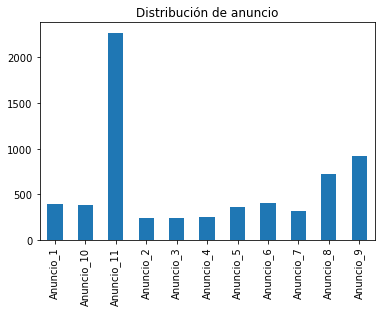

In [200]:
print(df.anuncio.value_counts())
plt.title('Distribución de anuncio')
df.anuncio.value_counts().sort_index().plot(kind='bar')

### Valores de `ubicacion`.

Buenos Aires, Argentina          5299
Rosario, Argentina                263
Cordoba, Argentina                261
Paraná, Argentina                 197
Mendoza, Argentina                173
Tucumán, Argentina                116
Neuquén, Argentina                 97
San Juan, Argentina                40
Comodoro Rivadavia, Argentina      38
Name: ubicacion, dtype: int64


<AxesSubplot:title={'center':'Distribución de ubicacion'}>

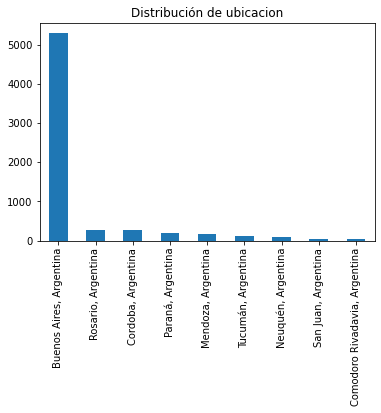

In [201]:
print(df.ubicacion.value_counts())
plt.title('Distribución de ubicacion')
df.ubicacion.value_counts().plot(kind='bar')

### Valores de `fecha`.

2020-08-14    2273
2020-07-17     919
2020-06-26     725
2020-05-23     405
2020-03-19     387
2020-07-31     380
2020-05-08     354
2020-06-04     310
2020-04-25     245
2020-04-10     243
2020-03-29     242
2020-08-25       1
Name: fecha, dtype: int64


<AxesSubplot:title={'center':'Distribución de fechas'}>

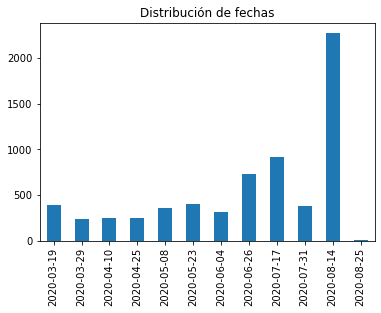

In [202]:
print(df['fecha'].map(lambda x: str(x)[:-15]).value_counts())
plt.title('Distribución de fechas')
df['fecha'].map(lambda x: str(x)[:-15]).value_counts().sort_index().plot(kind='bar')

Para poder aprovechar las funcionalidades después, es conveniente convertir el campo "fecha" en timestamp.

In [203]:
df['fecha'] = pd.to_datetime(df['fecha'])

### Valores de `tweet`.

Procedemos a chusmear los valores de los tweets.

In [204]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)
df.tweet.head(10)

0                                                                                                                                  alferdez alferdezprensa por favor qxsea a partir del sabafo la cuarentena los q fuimos hoy a trabajar no hemos podido organizarnos
2                      comodice inesazpelicueta que comiencen ya a elaborar remedios genericos asi no nos toma de sorpresa identica respuesta que tuvo el gobierno con la elaboracion del alcohol en gel o barbijos c parte del ministerio de defensa vamosss alberto
3                                                                     alferdez alferdezprensa a los que enganchan en la ruta yendose de vacaciones metanles una multa de 100 lucas y si se hacen los locos cuarentena presos con los giles mano dura companero abrazo
4                                                                                                                                            alferdezprensa porque no hacen que el indek mida el coronavirus asi lo ba

In [117]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

Ahora sí... ¡a trabajar en el modelo!